In [30]:
!pip install tsai optuna  optuna-integration -q

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import notebookcfa27bdb31 as ArrayGenerator
from tsai.all import *
from fastai.callback.all import *
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
import random

* To get consistent results

In [62]:
torch.manual_seed(37)  # tsai is built on it so this should work..... I think?
random.seed(37)
np.random.seed(37)

In [32]:
df = pd.read_pickle(
    "/kaggle/input/vhr-graduation-project-all/vhr_graduation_project_all.pickle"
)

In [33]:
X = np.array(df["ts"].to_list())
y = np.array(df["standardized_faults"])

In [34]:
# changed split method to split by bearing
raw_X, raw_y = ArrayGenerator.generate_dataset_array(
    dataset_category=4, ts=X, labels=y, split_method="bearing"
)

{'Faults classified': 'LXC, XC, Looseness', 'Channels taken': 'All', 'Labels array': 'Binary'}


In [35]:
def ts_without_NaN(ts):
    new_ts = []
    for value in ts:
        if not np.isnan(value):
            new_ts.append(value)
    return new_ts

In [36]:
# Padding function
def pad(array_3d):
    max_length = max(len(sub_arr) for arr in array_3d for sub_arr in arr)
    padded_array_3d = [
        [
            np.pad(sub_arr, (0, max_length - len(sub_arr)), mode="constant")
            for sub_arr in arr
        ]
        for arr in array_3d
    ]
    return np.array(padded_array_3d)

In [37]:
# Purging NaN values from our data to get its FFT
x_nonan = []
for bearing in raw_X:
    x_nonan.append(bearing[:, ~np.any(np.isnan(bearing), axis=0)])

* for training on raw timeseries without windowing

In [38]:
x_nonan_padded = pad(x_nonan)

In [39]:
#  applying earlystopping to get the best results and to prevent overfitting
callbacks = [
    PredictionDynamics(),
    EarlyStoppingCallback(monitor="f1_score", comp=np.greater, patience=3),
]

In [40]:
tfms = [None, [TSStandardize(by_var=False), Categorize()]]
batch_tfms = [TSStandardize(by_var=False)]

In [41]:
report_splits = get_splits(raw_y, valid_size=0.2, shuffle=True, show_plot=False)
X_train1, y_train1 = raw_X[report_splits[0]], raw_y[report_splits[0]]
X_test1, y_test1 = raw_X[report_splits[1]], raw_y[report_splits[1]]

In [42]:
def objective(trial):
    bs = trial.suggest_int("bs", 16, 128)  # suggest batch size
    apply_sliding_window = trial.suggest_categorical(
        "apply_sliding_window", [0, 1]
    )  # suggest whether to apply sliding window or not
    no_of_layers = trial.suggest_int("no_of_layers", 1, 2)  # suggest number of layers
    layers = []
    dropouts = []
    for i in range(no_of_layers):  # loop over every layer
        layers.append(
            trial.suggest_int("no_of_neurons_l{}".format(i), 8, 64)
        )  # suggest each layer size
        dropouts.append(
            trial.suggest_float("dropout_l{}".format(i), 0.0, 0.6)
        )  # suggest dropout rate

    lr = trial.suggest_float("lr", 1e-5, 1e-1)  # suggest learning rate

    if apply_sliding_window:
        overlap_pct = trial.suggest_float(
            "overlap_pct", 0.0, 1.0
        )  # suggest overlap pct
        with_fft = trial.suggest_categorical(
            "with_fft", [0, 1]
        )  # suggest whether to apply FFT or not

        if overlap_pct > 0.5:  # to avoid an error in ArrayGenerator

            window_size1 = trial.suggest_categorical(
                "window_size1", [2048, 4096]
            )  # suggest window size # to avoid CategoricalDistribution does not support dynamic value space error
            X_train, y_train = ArrayGenerator.apply_sliding_window(
                X_train1,
                y_train1,
                window_size=window_size1,
                with_fft=with_fft,
                overlap_pct=overlap_pct,
            )
            X_test, y_test = ArrayGenerator.apply_sliding_window(
                X_test1,
                y_test1,
                window_size=window_size1,
                with_fft=with_fft,
                overlap_pct=0,
            )

        elif overlap_pct > 0.25:
            window_size2 = trial.suggest_categorical(
                "window_size2", [2048, 4096, 8192]
            )  # suggest window size
            X_train, y_train = ArrayGenerator.apply_sliding_window(
                X_train1,
                y_train1,
                window_size=window_size2,
                with_fft=with_fft,
                overlap_pct=overlap_pct,
            )
            X_test, y_test = ArrayGenerator.apply_sliding_window(
                X_test1,
                y_test1,
                window_size=window_size2,
                with_fft=with_fft,
                overlap_pct=0,
            )
        else:
            window_size3 = trial.suggest_categorical(
                "window_size3", [2048, 4096, 8192, 16384]
            )  # suggest window size
            X_train, y_train = ArrayGenerator.apply_sliding_window(
                X_train1,
                y_train1,
                window_size=window_size3,
                with_fft=with_fft,
                overlap_pct=overlap_pct,
            )
            X_test, y_test = ArrayGenerator.apply_sliding_window(
                X_test1,
                y_test1,
                window_size=window_size3,
                with_fft=with_fft,
                overlap_pct=0,
            )
        train_balance_splits = get_splits(
            y_train,
            valid_size=0,
            balance=True,
            strategy="oversample",
            shuffle=True,
            show_plot=False,
        )
        X_train, y_train = (
            X_train[train_balance_splits[0]],
            y_train[train_balance_splits[0]],
        )
        X, y, splits = combine_split_data([X_train, X_test], [y_train, y_test])
        dls = get_ts_dls(
            X,
            y,
            splits=splits,
            tfms=tfms,
            shuffle_train=True,
            batch_tfms=batch_tfms,
            bs=[bs, 256],
        )
        seq_len = X_train.shape[-1]
    else:
        dls = get_ts_dls(
            x_nonan_padded,
            raw_y,
            splits=report_splits,
            tfms=tfms,
            shuffle_train=True,
            batch_tfms=batch_tfms,
            bs=[bs, 256],
        )
        seq_len = 16384
    model = MLP(
        dls.vars, dls.c, seq_len=seq_len, layers=layers, ps=dropouts, use_bn=True
    )
    learn = Learner(
        dls,
        model,
        lr=lr,
        metrics=[accuracy, Precision(), Recall(), F1Score(), BalancedAccuracy()],
    )

    with learn.no_logging(), learn.no_bar():
        learn.fit_one_cycle(15, cbs=callbacks)

    return learn.validate()[-2]  # return F1 score

# optimizing 

In [1]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=2400)
print('Study optimized')

Study optimized


# Results

In [55]:
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

optuna.importance.get_param_importances(study)

Study statistics: 
  Number of finished trials:  100
Best trial:
  Value:  0.825
  Params: 
    bs: 112
    apply_sliding_window: 1
    no_of_layers: 2
    no_of_neurons_l0: 25
    dropout_l0: 0.5534276339765585
    no_of_neurons_l1: 25
    dropout_l1: 0.2329294839045852
    lr: 0.008454377697753273
    overlap_pct: 0.1408325971604751
    with_fft: 1
    window_size3: 8192


{'bs': 0.3427436720866629,
 'apply_sliding_window': 0.20832075211837484,
 'lr': 0.14928279112492035,
 'no_of_layers': 0.13435134955467185,
 'dropout_l0': 0.10116692326094348,
 'no_of_neurons_l0': 0.06413451185442656}

In [45]:
plotly_config = {"staticPlot": True}
fig = plot_optimization_history(study)
fig.show(config=plotly_config)

In [46]:
fig = plot_param_importances(study)
fig.show(config=plotly_config)

* getting the variables ready to train on them 

In [47]:
layers = []
dropouts = []
if trial.params["no_of_layers"] == 1:
    layers = trial.params["no_of_neurons_l0"]
    dropouts = trial.params["dropout_l0"]
else:
    layers.append(trial.params["no_of_neurons_l0"])
    layers.append(trial.params["no_of_neurons_l1"])
    dropouts.append(trial.params["dropout_l0"])
    dropouts.append(trial.params["dropout_l1"])

# Training with the best found hyperparamters

In [50]:
if apply_sliding_window:
    if trial.params["overlap_pct"] > 0.5:  # to avoid an error in ArrayGenerator
        X_train, y_train = ArrayGenerator.apply_sliding_window(
            X_train1,
            y_train1,
            window_size=trial.params["window_size1"],
            with_fft=trial.params["with_fft"],
            overlap_pct=trial.params["overlap_pct"],
        )
        X_test, y_test = ArrayGenerator.apply_sliding_window(
            X_test1,
            y_test1,
            window_size=trial.params["window_size1"],
            with_fft=trial.params["with_fft"],
            overlap_pct=0,
        )

    elif trial.params["overlap_pct"] > 0.25:
        X_train, y_train = ArrayGenerator.apply_sliding_window(
            X_train1,
            y_train1,
            window_size=trial.params["window_size2"],
            with_fft=trial.params["with_fft"],
            overlap_pct=trial.params["overlap_pct"],
        )
        X_test, y_test = ArrayGenerator.apply_sliding_window(
            X_test1,
            y_test1,
            window_size=trial.params["window_size2"],
            with_fft=trial.params["with_fft"],
            overlap_pct=0,
        )
    else:
        X_train, y_train = ArrayGenerator.apply_sliding_window(
            X_train1,
            y_train1,
            window_size=trial.params["window_size3"],
            with_fft=trial.params["with_fft"],
            overlap_pct=trial.params["overlap_pct"],
        )
        X_test, y_test = ArrayGenerator.apply_sliding_window(
            X_test1,
            y_test1,
            window_size=trial.params["window_size3"],
            with_fft=trial.params["with_fft"],
            overlap_pct=0,
        )
    train_balance_splits = get_splits(
        y_train,
        valid_size=0,
        balance=True,
        strategy="oversample",
        shuffle=True,
        show_plot=False,
    )
    X_train, y_train = (
        X_train[train_balance_splits[0]],
        y_train[train_balance_splits[0]],
    )
    X, y, splits = combine_split_data([X_train, X_test], [y_train, y_test])
    dls = get_ts_dls(
        X,
        y,
        splits=splits,
        tfms=tfms,
        shuffle_train=True,
        batch_tfms=batch_tfms,
        bs=[trial.params["bs"], 256],
    )
    seq_len = X_train.shape[-1]
else:
    dls = get_ts_dls(
        x_nonan_padded,
        raw_y,
        splits=report_splits,
        tfms=tfms,
        shuffle_train=True,
        batch_tfms=batch_tfms,
        bs=[trial.params["bs"], 256],
    )
    seq_len = 16384
model = MLP(dls.vars, dls.c, seq_len=seq_len, layers=layers, ps=dropouts, use_bn=True)
learn = Learner(
    dls,
    model,
    lr=trial.params["lr"],
    metrics=[accuracy, Precision(), Recall(), F1Score(), BalancedAccuracy()],
)

learn.fit_one_cycle(15, cbs=callbacks);

valid == train


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score,time
0,0.642609,0.607451,0.623256,1.000000,0.068966,0.129032,0.534483,00:00
1,0.590337,0.540743,0.790698,0.738636,0.747126,0.742857,0.783719,00:00
2,0.527849,0.408494,0.851163,0.831325,0.793103,0.811765,0.841864,00:00
3,0.462774,0.389435,0.832558,0.904762,0.655172,0.760000,0.804149,00:00
4,0.398615,0.373801,0.841860,0.863014,0.724138,0.787500,0.823006,00:00
5,0.350632,0.467094,0.776744,0.669565,0.885057,0.762376,0.794091,00:00


No improvement since epoch 2: early stopping


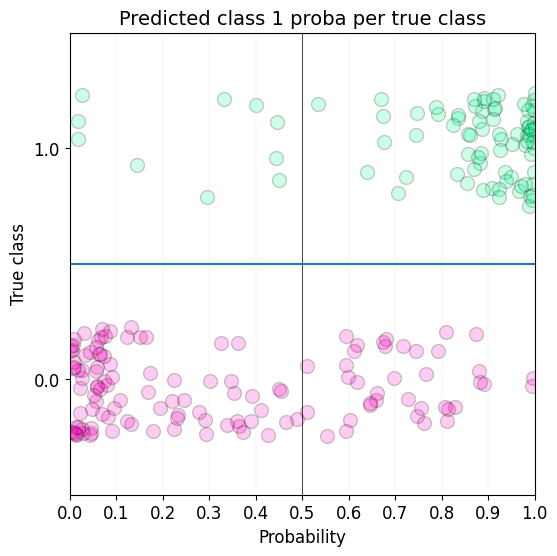

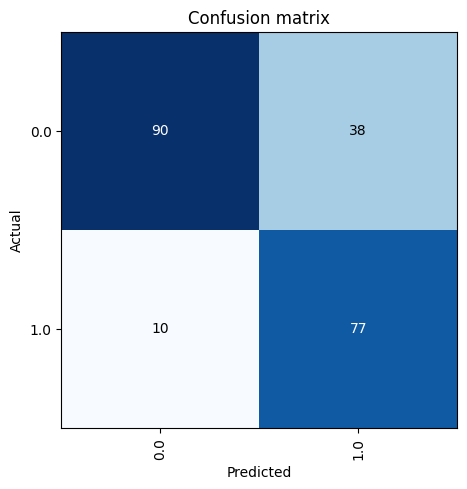

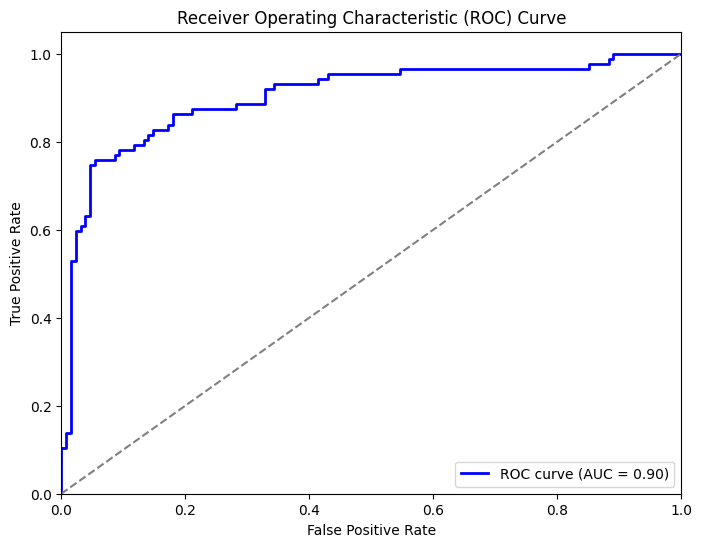

In [51]:
learn.show_probas()
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
valid_dl = dls.valid
valid_probas, valid_targets, valid_preds = learn.get_preds(
    dl=valid_dl, with_decoded=True
)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

positive_probs = valid_probas[:, 1]
# Draw ROC curve to help us adjust the threshold to a better value.
fpr, tpr, thresholds = roc_curve(valid_targets, positive_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()